In [1]:
from __future__ import print_function, division
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch.utils.data
import torch.nn.functional as F
import time
from datasets import __datasets__
import gc
import skimage
import skimage.io
import skimage.transform
import numpy as np
from PIL import Image
from datasets.data_io import get_transform
from models.bgnet import BGNet
from models.bgnet_plus import BGNet_Plus
from models.bgnet_plus_attn import BGNet_Plus_Attn
from utils import *
import time

In [2]:
# model = BGNet_Plus().cuda()
# checkpoint = torch.load('./pretrained_models/checkpoint_230_52.pth',map_location=lambda storage, loc: storage)
# # checkpoint = torch.load('./pretrained_models/Sceneflow-IRS-BGNet-Plus.pth',map_location=lambda storage, loc: storage)
# # checkpoint = torch.load('./pretrained_models/finetune_30_dsec.pth',map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint) 
# model.eval()

In [3]:
# model = BGNet_Plus().cuda()
# checkpoint = torch.load('./pretrained_models/checkpoint_000300.ckpt',map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint['model']) 
# model.eval()

In [4]:
model = BGNet_Plus_Attn().cuda()
checkpoint = torch.load('./logs/checkpoint_000400.ckpt',map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model']) 
model.eval()

BGNet_Plus_Attn(
  (softmax): Softmax(dim=1)
  (refinement_net): HourglassRefinement(
    (conv1): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv_start): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv1a): BasicConv(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fal

In [5]:
left_img = Image.open('/home/zhaoqinghao/DSEC/output/left/000167.png').convert('L')
right_img = Image.open('/home/zhaoqinghao/DSEC/output/right/000167.png').convert('L')
disp_true = Image.open('/home/zhaoqinghao/DSEC/output/disp/000167.png').convert('L')
left_img = left_img.crop((0, 0, 640, 448))
right_img = right_img.crop((0, 0, 640, 448))
disp_true = disp_true.crop((0, 0, 640, 448))

In [6]:
# left_img = Image.open('/home/zhaoqinghao/DSEC/output/left/000799.png').convert('L')
# right_img = Image.open('/home/zhaoqinghao/DSEC/output/right/000799.png').convert('L')
# disp_true = Image.open('/home/zhaoqinghao/DSEC/output/disp/000799.png').convert('L')
# left_img = left_img.crop((0, 0, 640, 448))
# right_img = right_img.crop((0, 0, 640, 448))
# disp_true = disp_true.crop((0, 0, 640, 448))

In [7]:
# left_img = Image.open('/home/zhaoqinghao/dataset/KITTI_2015/training/image_2/000001_10.png').convert('L')
# right_img = Image.open('/home/zhaoqinghao/dataset/KITTI_2015/training/image_3/000001_10.png').convert('L')
# disp_true = Image.open('/home/zhaoqinghao/dataset/KITTI_2015/training/disp_occ_0/000001_10.png').convert('L')
# left_img = left_img.crop((0, 0, 1216, 320))
# right_img = right_img.crop((0, 0, 1216, 320))
# disp_true = disp_true.crop((0, 0, 1216, 320))

In [8]:
left_img = np.ascontiguousarray(left_img, dtype=np.float32)
right_img = np.ascontiguousarray(right_img, dtype=np.float32)
disp_true = np.ascontiguousarray(disp_true, dtype=np.float32)

preprocess = get_transform()    # get_transform()函数返回一个转换列表，它将图像转换为 PyTorch 张量
left_img = preprocess(left_img)
right_img = preprocess(right_img)
disp_true = preprocess(disp_true)

In [9]:
with torch.no_grad():
    pred,_ = model(left_img.unsqueeze(0).cuda(), right_img.unsqueeze(0).cuda())
    pred,_ = model(left_img.unsqueeze(0).cuda(), right_img.unsqueeze(0).cuda())
time_start=time.time()
with torch.no_grad():
    pred,_ = model(left_img.unsqueeze(0).cuda(), right_img.unsqueeze(0).cuda())
# print time cost
print('time cost: ',(time.time()-time_start)*1000,'ms')
print('FPS: ',1/(time.time()-time_start))

time cost:  34.45720672607422 ms
FPS:  28.907892923110854


/disk2/users/M22_zhaoqinghao/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
disp_true = torch.squeeze(disp_true, 1)
disp_pred = pred.data.cpu()
mask = disp_true > 0

In [11]:
# End Point Error (EPE)
print('EPE: ', EPE_metric(disp_pred, disp_true, mask).item())
# percentage of disparity outliers D1, errors greater than max(3px, 0.05d∗)
print('D1: ',D1_metric(disp_pred, disp_true, mask).item() * 100, '%')
# errors larger than 1 pixels (1 pixel error / bad 1.0)
print('1-px err: ', Thres_metric(disp_pred, disp_true, mask, 1).item() * 100, '%')
print('2-px err: ', Thres_metric(disp_pred, disp_true, mask, 2).item() * 100, '%')
print('3-px err: ', Thres_metric(disp_pred, disp_true, mask, 3).item() * 100, '%')

EPE:  0.4688478410243988
D1:  0.44741290621459484 %
1-px err:  10.677969455718994 %
2-px err:  1.8024960532784462 %
3-px err:  0.44741290621459484 %


**BGNet_Plus_Attn on DSEC timesurface**:  
  
checkpoint_000400.pth:  
/home/zhaoqinghao/DSEC/output/left/000799.png
| Metric   | Value                 |
|----------|-----------------------|
| EPE      | 0.759494960308075     |
| D1       | 2.0355697721242905 %  |
| 1-px err | 19.223657250404358 %  |
| 2-px err | 3.6922890692949295 %  |
| 3-px err | 2.038576640188694 %   |

/home/zhaoqinghao/DSEC/output/left/000167.png

| Metric   | Value                 |
|----------|-----------------------|
| EPE      | 0.4688478410243988    |
| D1       | 0.44741290621459484 % |
| 1-px err | 10.677969455718994 %  |
| 2-px err | 1.8024960532784462 %  |
| 3-px err | 0.44741290621459484 % |

**BGNet_Plus on DSEC timesurface**:  
checkpoint_000300.pth:  
/home/zhaoqinghao/DSEC/output/left/000799.png  
| Metric   | Value                 |
|----------|-----------------------|
| EPE      | 0.7021940350532532    |
| D1       | 1.9213132560253143 %  |
| 1-px err | 18.50053369998932 %   |
| 2-px err | 3.9598900824785233 %  |
| 3-px err | 1.9228167831897736 %  |

/home/zhaoqinghao/DSEC/output/left/000167.png

| Metric   | Value                 |
|----------|-----------------------|
| EPE      | 0.4319567084312439    |
| D1       | 0.4067390225827694 %  |
| 1-px err | 9.164472669363022 %   |
| 2-px err | 1.573437824845314 %   |
| 3-px err | 0.40887976065278053 % |

Sceneflow-IRS-BGNet-Plus.pth:  

| Metric  | Value                 |
|---------|-----------------------|
| EPE     | 1.8176898956298828    |
| D1      | 14.150236546993256 %  |
| 1-px err| 51.73506140708923 %   |
| 2-px err| 25.031575560569763 %  |
| 3-px err| 14.223021268844604 %  |

/disk2/users/M22_zhaoqinghao/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


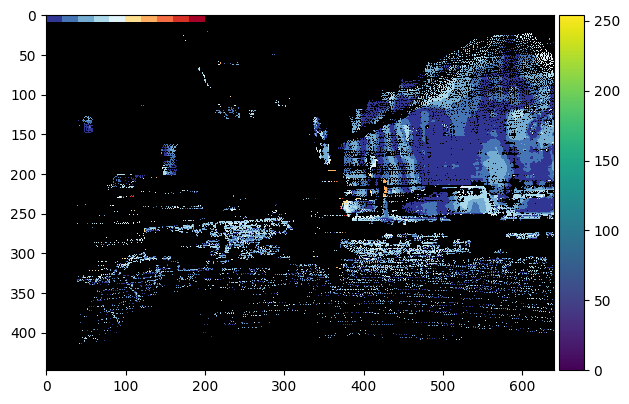

In [12]:
errormap = disp_error_image_func.apply(pred, disp_true)
errormap = errormap.squeeze(0)
errormap = errormap.cpu().numpy() * 256
errormap = errormap.transpose(1, 2, 0)
skimage.io.imshow(errormap.astype('uint16'))

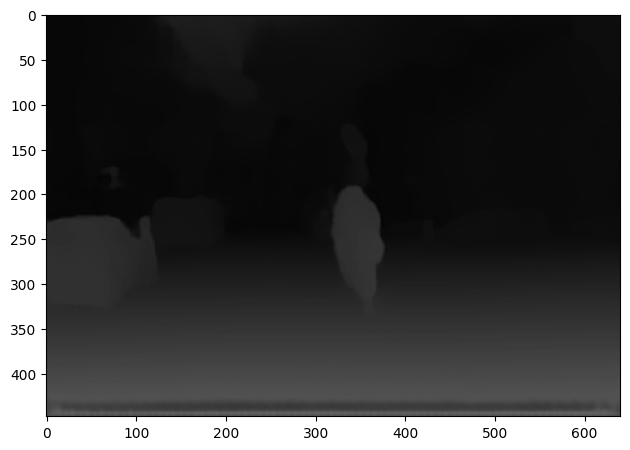

In [13]:
# # save disp
pred = pred[0].data.cpu().numpy() * 256
# skimage.io.imsave('sample_disp.png',pred.astype('uint16'))
skimage.io.imshow(pred.astype('uint16'))

